<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S4_coding_drilldown_code/EVA4S5F10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # naive way of changing learning rate


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step() # This will make a difference eventually when enabled in the next cell
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1341235488653183 Batch_id=468 Accuracy=86.67: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0589, Accuracy: 9833/10000 (98.33%)

EPOCH: 1


Loss=0.05812348052859306 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0405, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.04791807755827904 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:19<00:00, 23.88it/s]



Test set: Average loss: 0.0288, Accuracy: 9919/10000 (99.19%)

EPOCH: 3


Loss=0.09387657791376114 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]



Test set: Average loss: 0.0285, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.04637422785162926 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]



Test set: Average loss: 0.0289, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.05864874646067619 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]



Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.08831703662872314 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.017571188509464264 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.0360272116959095 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]



Test set: Average loss: 0.0228, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.08005698770284653 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]



Test set: Average loss: 0.0211, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.020217416808009148 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]



Test set: Average loss: 0.0237, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.025659767910838127 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:19<00:00, 24.26it/s]



Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.01192400511354208 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.026018263772130013 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0240, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.019745342433452606 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.05463061109185219 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0202, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.049181804060935974 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.011388356797397137 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]



Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.012341405265033245 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]



Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.0013479600893333554 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0176, Accuracy: 9938/10000 (99.38%)



In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # naive way of changing learning rate (reducing it going forward, in this case after 6 epochs)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.11815101653337479 Batch_id=468 Accuracy=88.29: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0727, Accuracy: 9792/10000 (97.92%)

EPOCH: 1


Loss=0.027911392971873283 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0401, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.046472106128931046 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0325, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.025384172797203064 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]



Test set: Average loss: 0.0379, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.08962127566337585 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]



Test set: Average loss: 0.0303, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.02106778509914875 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]



Test set: Average loss: 0.0269, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.01112081203609705 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.01300661638379097 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]



Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.035297323018312454 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]



Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.021288059651851654 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]



Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.008604339323937893 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.006294197868555784 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]



Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.05612550303339958 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.07131198793649673 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.99it/s]



Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.048405032604932785 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]



Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.00593481445685029 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.041817307472229004 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.03906850516796112 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]



Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.011225209571421146 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.0069035072810947895 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

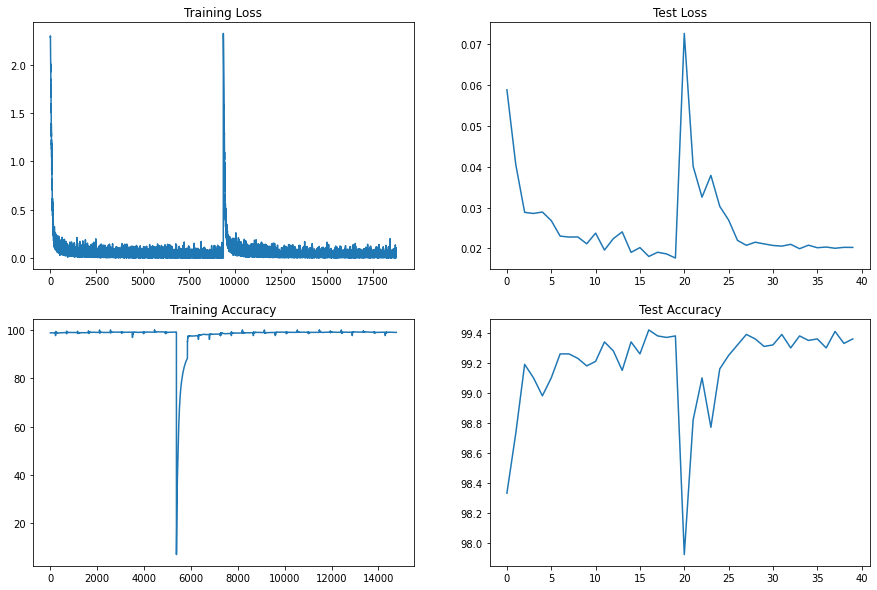

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:
- Add LR Scheduler

Results:
- Parameters: 13.8k
- Best Train Accuracy: 99.21
- Best Test Accuracy: 99.41 (17th epoch)

Analysis:
- Finding a good LR schedule is hard. We have tried to make it effective by reducing LR by 10th after the 6th epoch.
- It did help in getting to 99.4 or faster, but the final accuracy is not more than 99.5. Possibly a good scheduler can do wonders here!